In [ ]:
import numpy as np
import pandas as pd

import string

import tensorflow as tf
import keras
from keras import backend as K
from keras.engine.topology import Layer
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, GlobalMaxPooling1D, Bidirectional, Dropout, TimeDistributed
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping

import json

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id':"1JJKTmOX7NnWHzx4HqXcSq9OKslrVBVuT"})
downloaded.GetContentFile('lyrics.csv')

# Data Preprocessing

In [ ]:
def formatdata(path):
    data = pd.read_csv(path)
    data = data[data['lyrics'].notnull()]
    
    # Remove punctuation
    data['lyrics'] = data['lyrics'].str.replace("[-\?.,\/#!$%\^&\*;:{}=\_~()]", ' ')
    
    # Remove song identifiers using regex
    data['lyrics'] = data['lyrics'].str.replace("\[(.*?)\]", ' ')
    data['lyrics'] = data['lyrics'].str.replace("' | '", ' ')
    data['lyrics'] = data['lyrics'].str.replace('x[0-9]+', ' ')
    
    # Remove lyricless songs 
    data = data[data['lyrics'].str.strip().str.lower() != 'instrumental']
    
    # fix stuff like [verse] and 'repeat x2'
    data = data[~data['lyrics'].str.contains(r'[^\x00-\x7F]+')]
    data = data[data['lyrics'].str.strip() != '']
    data = data[data['genre'].str.lower() != 'not available']
    
    # Grouping Folk and Country to one genre
    data['genre'] = np.where(data['genre'] == "Folk", "Country", data["genre"])
    data = data[data['genre'].isin(['Rock', 'Pop', 'Country', 'Hip-Hop'])]

    return data.copy()

In [ ]:
data = formatdata('lyrics.csv')

In [ ]:
data['genre'].unique()

array(['Pop', 'Hip-Hop', 'Rock', 'Country'], dtype=object)

In [ ]:
from collections import Counter 
Counter(data['genre'])

Counter({'Country': 15847, 'Hip-Hop': 22654, 'Pop': 34137, 'Rock': 100044})

In [ ]:
lyrics = data['lyrics'].values 

label_encoder = LabelEncoder()
indexed_labels = np.array(label_encoder.fit_transform(data['genre'].values))

In [ ]:
max_words = 30000

tokenizer = text.Tokenizer(num_words=max_words, oov_token="<UNK>")
tokenizer.fit_on_texts(lyrics)

tokenizer.word_index = {v:i for v,i in tokenizer.word_index.items() if i <= max_words}
tokenizer.word_index[tokenizer.oov_token] = max_words+1

In [ ]:
MAX_NUM_LINES = 60
MAX_WORDS_PER_LINE = 10 

def get_indexed_data_by_line():
    # Use this zero vector when padding lines.
    zero_line_vector = MAX_WORDS_PER_LINE*[tokenizer.word_index[tokenizer.oov_token]]
    indexed_data = []
    for txt in lyrics:
        lines = txt.split('\n')
        lines = tokenizer.texts_to_sequences(lines)[0]
        wordIndices = [lines[i:i+MAX_WORDS_PER_LINE] for i in range(0, len(lines), MAX_WORDS_PER_LINE)]
        song_padded = wordIndices[:MAX_NUM_LINES] + (MAX_NUM_LINES-len(wordIndices)) * [zero_line_vector]
        padded = sequence.pad_sequences(song_padded, maxlen=MAX_WORDS_PER_LINE)
        indexed_data.append(padded) 
    
    return indexed_data

In [ ]:
idx_data = get_indexed_data_by_line()

In [ ]:
idx_data_1 = np.array(idx_data)

In [ ]:
number_test = 34536

In [ ]:
random_indexes = np.random.permutation(len(indexed_labels))
idx_data_1 = idx_data_1[random_indexes]
indexed_labels = indexed_labels[random_indexes]

X_train = idx_data_1[:-number_test]
y_train = indexed_labels[:-number_test]
X_test  = idx_data_1[-number_test:]
y_test  = indexed_labels[-number_test:]

In [ ]:
vocab_size = max_words + 2

# Implementation of Attention Layer

In [ ]:
class AttLayer(Layer):
    def __init__(self, **kwargs):
        self.hidden_dim = attention_size
        super(AttLayer,self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='kernel', shape=(input_shape[-1], self.hidden_dim), initializer = 'he_normal', trainable=True)
        self.bw = self.add_weight(name='bias', shape=(self.hidden_dim,), initializer = 'zero', trainable=True)
        self.uw = self.add_weight(name='uw', shape=(self.hidden_dim,), initializer = 'he_normal', trainable=True)
        self._trainable_weights = [self.W, self.bw, self.uw]
        super(AttLayer,self).build(input_shape)

    def call(self, x, mask=None):
        x_reshaped = tf.reshape(x, [K.shape(x)[0]*K.shape(x)[1], K.shape(x)[-1]])
        ui = K.tanh(K.dot(x_reshaped, self.W) + self.bw)
        intermed = tf.reduce_sum(tf.multiply(self.uw, ui), axis=1)

        weights = tf.nn.softmax(tf.reshape(intermed, [K.shape(x)[0], K.shape(x)[1]]), axis=-1)
        weights = tf.expand_dims(weights, axis=-1)

        weighted_input = x*weights
        return K.sum(weighted_input, axis=1)

    def get_output_shape_for(self, input_shape):
        return (input_shape[0], input_shape[2])
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[2])

# Initial HAN-GRU Model

In [ ]:
attention_size = 200
embedding_vector_length = 128
hidden_size = 64 
dropout = .5

model1 = Sequential()
model1.add(Embedding(vocab_size, embedding_vector_length, input_shape=(MAX_WORDS_PER_LINE, )))
model1.add(Bidirectional(GRU(hidden_size, return_sequences=True)))
model1.add(AttLayer())
model1.add(Dropout(.5))

model1_final = Sequential()
model1_final.add(TimeDistributed(model1, input_shape=(MAX_NUM_LINES, MAX_WORDS_PER_LINE)))
model1_final.add(Bidirectional(GRU(hidden_size, return_sequences=True)))
model1_final.add(AttLayer())
model1_final.add(Dropout(.5))
model1_final.add(Dense(4, activation='softmax'))

model1_final.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model1_final.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_2 (TimeDist (None, 60, 128)           3940752   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 60, 128)           74496     
_________________________________________________________________
att_layer_5 (AttLayer)       (None, 128)               26000     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 516       
Total params: 4,041,764
Trainable params: 4,041,764
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model1_final.fit(X_train.squeeze(), y_train, epochs=5, batch_size=64)

Epoch 1/5
2159/2159 [==============================] - 147s 68ms/step - loss: 0.7804 - accuracy: 0.6993
Epoch 2/5
2159/2159 [==============================] - 149s 69ms/step - loss: 0.6554 - accuracy: 0.7435
Epoch 3/5
2159/2159 [==============================] - 148s 69ms/step - loss: 0.5819 - accuracy: 0.7720
Epoch 4/5
2159/2159 [==============================] - 146s 67ms/step - loss: 0.5141 - accuracy: 0.7981
Epoch 5/5
2159/2159 [==============================] - 145s 67ms/step - loss: 0.4495 - accuracy: 0.8249


In [ ]:
model1_final.evaluate(X_test, y_test)

1080/1080 [==============================] - 9s 8ms/step - loss: 0.8266 - accuracy: 0.6982


[0.8265723586082458, 0.698170006275177]

In [ ]:
f1_score(np.argmax(model2_final.predict(X_test), axis=1), y_test, average='weighted')

0.6973063396569681

# Final Model After Parameter Tuning

In [ ]:
attention_size = 100
embedding_vector_length = 32
hidden_size = 50 
dropout = .5

model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_shape=(MAX_WORDS_PER_LINE, )))
model.add(Bidirectional(GRU(hidden_size, return_sequences=True)))
model.add(AttLayer())
model.add(Dropout(.5))

model_final = Sequential()
model_final.add(TimeDistributed(model, input_shape=(MAX_NUM_LINES, MAX_WORDS_PER_LINE)))
model_final.add(Bidirectional(GRU(hidden_size, return_sequences=True)))
model_final.add(AttLayer())
model_final.add(Dropout(.5))
model_final.add(Dense(4, activation='softmax'))

#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
model_final.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_final.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 60, 100)           995464    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 60, 100)           45600     
_________________________________________________________________
att_layer_1 (AttLayer)       (None, 100)               10200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 404       
Total params: 1,051,668
Trainable params: 1,051,668
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model_final.fit(X_train.squeeze(), y_train, epochs=4, batch_size=64)

Epoch 1/4
2159/2159 [==============================] - 66s 30ms/step - loss: 0.8031 - accuracy: 0.6935
Epoch 2/4
2159/2159 [==============================] - 65s 30ms/step - loss: 0.6726 - accuracy: 0.7368
Epoch 3/4
2159/2159 [==============================] - 65s 30ms/step - loss: 0.6069 - accuracy: 0.7625
Epoch 4/4
2159/2159 [==============================] - 65s 30ms/step - loss: 0.5563 - accuracy: 0.7818


In [ ]:
model_final.evaluate(X_test, y_test)

1080/1080 [==============================] - 7s 7ms/step - loss: 0.7351 - accuracy: 0.7208


[0.7350972890853882, 0.7207841277122498]

In [ ]:
f1_score(np.argmax(model_final.predict(X_test), axis=1), y_test, average='weighted')

0.7298769552344357

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

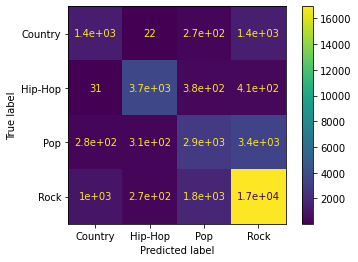

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test, np.argmax(model_final.predict(X_test), axis=1)), display_labels=label_encoder.classes_).plot()
plt.savefig("HANGRU-full.png")